In [129]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Activation, Dropout, Embedding, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.svm import SVC
from sklearn import model_selection, metrics, pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from matplotlib import pyplot
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [3]:
train_data = pd.read_csv('data/spooky-company/train.csv')
test_data = pd.read_csv('data/spooky-company/test.csv')
train_data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [137]:
test_data.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [4]:
train_data.shape, test_data.shape

((19579, 3), (8392, 2))

# 1. Label Encode Category 

In [5]:
# Category to integers from 0,1,2
label_encoder = LabelEncoder()
train_label = train_data.author.values
y = label_encoder.fit_transform(train_label)

In [6]:
train_label

array(['EAP', 'HPL', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object)

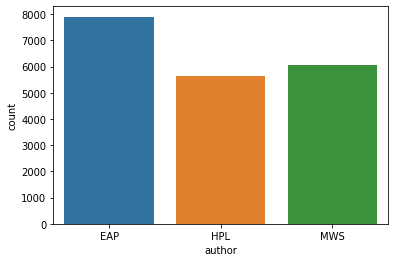

In [7]:
sns.countplot(x='author', data=train_data)

In [8]:
train_data.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [136]:
test_data.author.value_counts()

AttributeError: 'DataFrame' object has no attribute 'author'

In [9]:
X = train_data.text.values

In [ ]:
X_test = test_data.text.values
y_test = test_data.aut

# 2. Split Dataset

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1,
                                                     shuffle=True)

In [11]:
X_train.shape, y_valid.shape

((17621,), (1958,))

In [ ]:
X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1,
                                                     shuffle=True)

# 3. Basic Model

In [12]:
def vectorise(vector, X_train, X_valid):
    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    vector.fit(list(X_train) + list(X_valid))
    xtrain_vec =  vector.transform(X_train) 
    xvalid_vec = vector.transform(X_valid)
    return xtrain_vec, xvalid_vec


In [13]:
def train_predict(xtrain_vec, xvalid_vec, y_train, clf):
    # Fitting a simple Logistic Regression on TFIDF
    clf.fit(xtrain_vec, y_train)
    predictions = clf.predict_proba(xvalid_vec)
    print("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))


In [14]:
# Using TFIDF
tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [15]:
# Using CV
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

In [16]:
x_tfidf,v_tfidf = vectorise(tfidf,X_train, X_valid)

In [17]:
x_ctv,v_ctv = vectorise(ctv,X_train, X_valid)

# 3.1 Logistic Regression

In [19]:
clf = LogisticRegression(C=1.0)

In [20]:
# TFIDF
train_predict(x_tfidf,v_tfidf,y_train, clf)

logloss: 0.572 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
# CV
train_predict(x_ctv,v_ctv,y_train, clf)

logloss: 0.527 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# 3.2 Using Naive base

In [59]:
clf = MultinomialNB()

In [60]:
# TFIDF
train_predict(x_tfidf,v_tfidf,y_train, clf)

logloss: 0.578 


In [61]:
# CV
train_predict(x_ctv,v_ctv,y_train, clf)

logloss: 0.485 


In [62]:
# NB does better with the CV data

# 3.3 SVM

In [18]:
# for svm we have to Apply SVD, I chose 120 components. 
# 120-200 components are good enough for SVM model.

svd = TruncatedSVD(n_components=120)
svd.fit(x_tfidf)
xtrain_svd = svd.transform(x_tfidf)
xvalid_svd = svd.transform(v_tfidf)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [22]:
clf = SVC(C=1.0, probability=True) # since we need probabilities

In [67]:
train_predict(xtrain_svd_scl, xvalid_svd_scl, y_train, clf)

logloss: 0.732 


In [68]:
# SVC doesnt do well on this problem

# 3.4 XGB

In [70]:
clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

In [71]:
# TFIDF
train_predict(x_tfidf,v_tfidf,y_train, clf)

logloss: 0.782 


In [72]:
# CV
train_predict(x_ctv,v_ctv,y_train, clf)

logloss: 0.773 


In [73]:
# XGB also not doing well

# 4. Grid Search

In [74]:
mll_scorer = metrics.make_scorer(multiclass_logloss, 
                                 greater_is_better=False, 
                                 needs_proba=True)

In [75]:
# Initialize SVD
svd = TruncatedSVD()

In [76]:
# Initialize the standard scaler 
scl = StandardScaler()

In [77]:
# We will use logistic regression here..
lr_model = LogisticRegression()

In [78]:
# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [79]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [80]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, 
                     scoring=mll_scorer,verbose=10, n_jobs=-1, 
                     iid=True, refit=True, cv=2)

In [82]:
# Fit Grid Search Model
model.fit(x_tfidf, y_train)  
# we can use the full data here but im only using xtrain

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:   11.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:   13.0s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:   16.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:   17.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   18.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('svd',
                                        TruncatedSVD(algorithm='randomized',
                                                     n_components=2, n_iter=5,
                                                     random_state=None,
                                                     tol=0.0)),
                                       ('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_

In [83]:
print("Best score: %0.3f" % model.best_score_)

Best score: -0.738
Best parameters set:


In [84]:
best_parameters = model.best_estimator_.get_params()
print("Best parameters set:")
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'
	svd__n_components: 180


In [88]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(x_tfidf, y_train)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: -0.492
Best parameters set:
	nb__alpha: 0.1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0217s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


# 5. Word Vectors

In [19]:
# load the GloVe vectors in a dictionary: 
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    with open(gloveFile,'r', encoding='utf8') as f:
        embeddings = {}
        for line in f:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.asarray(splitLine[1:], dtype='float32')
            embeddings[word] = embedding
    print("Done.",len(embeddings)," words loaded!")
    return embeddings

In [20]:
glove_embeddings = loadGloveModel('pretrained-models/glove.42B.300d.txt')

Loading Glove Model
Done. 1917495  words loaded!


In [ ]:
import pickle
with open('glove.6B.300d.pkl', 'wb') as fp:
    pickle.dump(glove_embeddings, fp)

In [21]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(glove_embeddings[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [22]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(X_train)]
xvalid_glove = [sent2vec(x) for x in tqdm(X_valid)]

100%|██████████| 1958/1958 [00:00<00:00, 3212.31it/s]


In [23]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [24]:
# XGBoost on Glove
# Fitting a simple xgboost on glove features
clf = XGBClassifier(nthread=10, silent=False)

In [25]:
train_predict(xtrain_glove,xvalid_glove,y_train, clf)

logloss: 0.749 


In [26]:
# Fine tuining parameters
clf = XGBClassifier(max_depth=7, n_estimators=200, 
                        colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, 
                        learning_rate=0.1, silent=False)

In [27]:
train_predict(xtrain_glove,xvalid_glove,y_train, clf)

logloss: 0.726 


In [ ]:
# We can see a slight improvement after tuining

# 6. Deep Learning

In [25]:
# scale the data before any neural net:
scl = StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [26]:
# we need to binarize the labels for the neural net
ytrain_enc = to_categorical(y_train)
yvalid_enc = to_categorical(y_valid)

In [27]:
type(ytrain_enc)
ytrain_enc[:10]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [28]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

In [29]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Train on 17621 samples, validate on 1958 samples
Epoch 1/5
17621/17621 [==============================] - 4s 199us/sample - loss: 0.9412 - val_loss: 0.7419
Epoch 2/5
17621/17621 [==============================] - 1s 66us/sample - loss: 0.7242 - val_loss: 0.7132
Epoch 3/5
17621/17621 [==============================] - 1s 67us/sample - loss: 0.6565 - val_loss: 0.6966
Epoch 4/5
17621/17621 [==============================] - 2s 124us/sample - loss: 0.6067 - val_loss: 0.6854
Epoch 5/5
17621/17621 [==============================] - 1s 67us/sample - loss: 0.5808 - val_loss: 0.6854


# 6.1 LSTM

In [31]:
# with LSTMs we need to tokenize the text data
# using keras tokenizer here
token = Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(X_train) + list(X_valid))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_valid)
xtest_seq = token.texts_to_sequences(X)

In [32]:
# zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [33]:
xtrain_pad[4]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,    13,     8,    36,   329,   876,     4,
           1,   379,    82,    37,    88,  3278,  1730,     2,   778,
           9, 10108,    66,   196,    48,   587,    25,  2678,   118,
          76,    24,    48,   112, 16050,     2,  3939], dtype=int32)

In [34]:
word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'a': 5,
 'i': 6,
 'in': 7,
 'was': 8,
 'that': 9,
 'my': 10,
 'it': 11,
 'had': 12,
 'he': 13,
 'with': 14,
 'his': 15,
 'as': 16,
 'for': 17,
 'which': 18,
 'but': 19,
 'not': 20,
 'at': 21,
 'me': 22,
 'from': 23,
 'by': 24,
 'is': 25,
 'this': 26,
 'on': 27,
 'be': 28,
 'her': 29,
 'were': 30,
 'have': 31,
 'all': 32,
 'you': 33,
 'we': 34,
 'or': 35,
 'no': 36,
 'an': 37,
 'one': 38,
 'so': 39,
 'him': 40,
 'when': 41,
 'been': 42,
 'they': 43,
 'upon': 44,
 'there': 45,
 'could': 46,
 'she': 47,
 'its': 48,
 'would': 49,
 'more': 50,
 'now': 51,
 'their': 52,
 'what': 53,
 'some': 54,
 'our': 55,
 'are': 56,
 'into': 57,
 'than': 58,
 'will': 59,
 'very': 60,
 'who': 61,
 'if': 62,
 'them': 63,
 'only': 64,
 'then': 65,
 'up': 66,
 'these': 67,
 'before': 68,
 'about': 69,
 'any': 70,
 'man': 71,
 'time': 72,
 'yet': 73,
 'out': 74,
 'said': 75,
 'even': 76,
 'did': 77,
 'your': 78,
 'might': 79,
 'after': 80,
 'old': 81,
 'like': 82,
 'f

In [35]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 25943/25943 [00:00<00:00, 162582.41it/s]


In [74]:
input_shape = len(word_index) + 1, 300
output_shape = 3 # no of categories

In [75]:
# A simple LSTM with glove embeddings and two dense layers
def define_model(input_shape, output_shape, BiDir=False, no_of_units=100):
    model = Sequential()
    model.add(Embedding(input_shape[0],input_shape[1],weights=[embedding_matrix],input_length=max_len,
                         trainable=False))
    model.add(SpatialDropout1D(0.3))
    if BiDir:
        model.add(Bidirectional(LSTM(no_of_units, dropout=0.3, recurrent_dropout=0.3))) 
    else:
        model.add(LSTM(no_of_units, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_shape))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [133]:
# Train model
def train_model(model, xtrain, ytrain, xval, yval, batch_size, save_file_name):
    # Save best model and earlystop calback
    saveBestModel = ModelCheckpoint(save_file_name +'.hdf5', monitor='val_acc', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='auto', period=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    # Fit the model with early stopping callback
    
    
    model.fit(xtrain, y=ytrain, batch_size=batch_size, epochs=100,verbose=1, 
              validation_data=(xvalid, yvalid), callbacks=[saveBestModel,earlystop])
    return model
    

In [135]:
def evaluate_model(model,xtest, ytest):
    score, acc = model.evaluate(xtest, ytest)
    return score, acc

In [130]:
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, 
                          patience=5, verbose=0, mode='auto')


In [131]:
# Save best model
saveBestModel = ModelCheckpoint('best_weight_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='auto', period=1)

[09:45:22] WARNING `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [38]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[saveBestModel,earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 25s 1ms/sample - loss: 1.0380 - val_loss: 0.9267
Epoch 2/100
17621/17621 [==============================] - 18s 1ms/sample - loss: 0.9173 - val_loss: 0.8560
Epoch 3/100
17621/17621 [==============================] - 19s 1ms/sample - loss: 0.8575 - val_loss: 0.7961
Epoch 4/100
17621/17621 [==============================] - 19s 1ms/sample - loss: 0.8242 - val_loss: 0.7835
Epoch 5/100
17621/17621 [==============================] - 18s 1ms/sample - loss: 0.8035 - val_loss: 0.7213
Epoch 6/100
17621/17621 [==============================] - 15s 848us/sample - loss: 0.7799 - val_loss: 0.7037
Epoch 7/100
17621/17621 [==============================] - 17s 980us/sample - loss: 0.7643 - val_loss: 0.6910
Epoch 8/100
17621/17621 [==============================] - 19s 1ms/sample - loss: 0.7354 - val_loss: 0.6641
Epoch 9/100
17621/17621 [==============================] - 18s 1ms/sample - loss: 0

In [139]:
for key in model.history:
    print(key)

TypeError: 'History' object is not iterable

In [ ]:
score, acc = model.evaluate(xvalid_pad, yvalid_enc)

In [39]:
model.history.history

{'loss': [1.0379848306359407,
  0.9173327061227634,
  0.8574646276957087,
  0.8242216144833403,
  0.8034976589768342,
  0.7799073702820476,
  0.7643006349028013,
  0.7353509851186921,
  0.724269477996076,
  0.7123113883474576,
  0.689246386480713,
  0.6715588240785568,
  0.6521351950629048,
  0.6413079424665096,
  0.6244352102502914,
  0.6051454433862552,
  0.5946527099265704,
  0.5757192616653215,
  0.5628070246550236,
  0.5587710691569957,
  0.5380761694552293,
  0.522983833891222,
  0.5080660740874978,
  0.5046122314274281,
  0.4898167773831764,
  0.48062349479671074,
  0.4693717915579786,
  0.4676621284270948,
  0.4630531273914597,
  0.4440211820843257,
  0.4368489836108758,
  0.42134973746911264,
  0.4158481401933335,
  0.41776179673350916,
  0.4076818985519179,
  0.39176644071717587,
  0.38989092371979417,
  0.3863737351233014],
 'val_loss': [0.9266805878333344,
  0.8560298296477383,
  0.796139147722441,
  0.7834595330401997,
  0.7212868661023257,
  0.7037076699843324,
  0.691045

In [61]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(111)
        pyplot.title("Cross Entropy Loss")
        pyplot.plot(histories["loss"], color="blue", label="train")
        pyplot.plot(histories["val_loss"], color="orange", label="test")
    pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


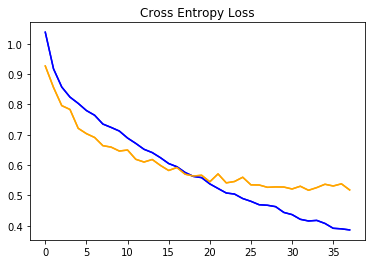

In [62]:
summarize_diagnostics(model.history.history)

# 6.2 Bi-Directional LSTM

In [76]:
model = define_model(input_shape, output_shape,BiDir=True, no_of_units=300)

In [77]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 103s 6ms/sample - loss: 1.0070 - val_loss: 0.9010
Epoch 2/100
17621/17621 [==============================] - 78s 4ms/sample - loss: 0.8752 - val_loss: 0.8077
Epoch 3/100
17621/17621 [==============================] - 76s 4ms/sample - loss: 0.8252 - val_loss: 0.7349
Epoch 4/100
17621/17621 [==============================] - 78s 4ms/sample - loss: 0.7988 - val_loss: 0.7332
Epoch 5/100
17621/17621 [==============================] - 73s 4ms/sample - loss: 0.7837 - val_loss: 0.7149
Epoch 6/100
17621/17621 [==============================] - 79s 4ms/sample - loss: 0.7537 - val_loss: 0.6988
Epoch 7/100
17621/17621 [==============================] - 80s 5ms/sample - loss: 0.7430 - val_loss: 0.6935
Epoch 8/100
17621/17621 [==============================] - 79s 4ms/sample - loss: 0.7151 - val_loss: 0.6646
Epoch 9/100
17621/17621 [==============================] - 77s 4ms/sample - loss: 0.69

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


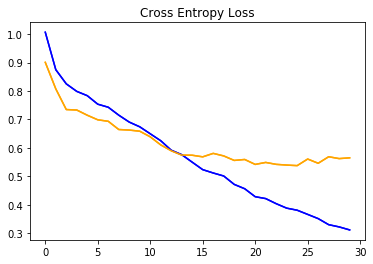

In [78]:
summarize_diagnostics(model.history.history)

# 6.3 GRU

In [79]:
# GRU with glove embeddings and two dense layers
def define_model_GRU(input_shape, output_shape):
    model = Sequential()
    model.add(Embedding(input_shape[0],input_shape[1],weights=[embedding_matrix],input_length=max_len,
                         trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(SpatialDropout1D(0.3))
    
    model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_shape))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [80]:
model = define_model_GRU(input_shape, output_shape)

In [81]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 73s 4ms/sample - loss: 1.0624 - val_loss: 0.9609
Epoch 2/100
17621/17621 [==============================] - 78s 4ms/sample - loss: 0.9639 - val_loss: 0.8712
Epoch 3/100
17621/17621 [==============================] - 72s 4ms/sample - loss: 0.9136 - val_loss: 0.8190
Epoch 4/100
17621/17621 [==============================] - 72s 4ms/sample - loss: 0.8694 - val_loss: 0.7841
Epoch 5/100
17621/17621 [==============================] - 73s 4ms/sample - loss: 0.8456 - val_loss: 0.7430
Epoch 6/100
17621/17621 [==============================] - 72s 4ms/sample - loss: 0.8249 - val_loss: 0.7273
Epoch 7/100
17621/17621 [==============================] - 66s 4ms/sample - loss: 0.8095 - val_loss: 0.7082
Epoch 8/100
17621/17621 [==============================] - 69s 4ms/sample - loss: 0.7944 - val_loss: 0.6992
Epoch 9/100
17621/17621 [==============================] - 70s 4ms/sample - loss: 0.762

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


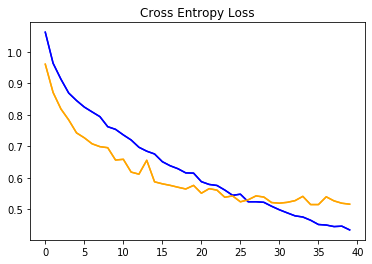

In [107]:
summarize_diagnostics(model.history.history)

In [86]:
min_val_loss = np.min(model.history.history['val_loss'])
min_val_loss

0.5153160764321122

In [109]:
xtrain_pad.shape

(17621, 70)

In [120]:
xtrain_pad[0].shape

(70,)

In [125]:
test = np.expand_dims(xtrain_pad[10], axis=0)
test.shape

(1, 70)

In [126]:
model.predict_classes(test)

array([2])

In [128]:
ytrain_enc[10]

array([0., 0., 1.], dtype=float32)

# 7. Ensembling

In [90]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
import os
import sys
import logging

In [91]:
logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)

In [92]:
class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification'
                 , optimize=roc_auc_score,lower_is_better=False, 
                 save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros(
                (train_prediction_shape[0],
                 train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(
                    self.train_prediction_dict[0], self.y_enc):
                    
                    logger.info("Training Level %d Fold # %d. Model # %d", 
                                level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [93]:
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [x_tfidf, x_ctv, x_tfidf, x_ctv], 
                   1: [xtrain_glove]}
test_data_dict = {0: [v_tfidf, v_ctv, v_tfidf, v_ctv], 
                  1: [xvalid_glove]}

In [95]:
model_dict = {0: [LogisticRegression(), LogisticRegression(), 
                  MultinomialNB(alpha=0.1), MultinomialNB()],
              1: [XGBClassifier(silent=True, n_estimators=120, 
                                    max_depth=7)]}

In [96]:
ens = Ensembler(model_dict=model_dict, num_folds=3, 
                task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, 
                save_path='')

In [97]:
ens.fit(train_data_dict, y_train, lentrain=xtrain_glove.shape[0])

[17:24:22] INFO Found 3 classes
[17:24:22] INFO Training Level 0 Fold # 1. Model # 0
[17:24:24] INFO Predicting Level 0. Fold # 1. Model # 0
[17:24:24] INFO Level 0. Fold # 1. Model # 0. Validation Score = 0.626621
[17:24:24] INFO Training Level 0 Fold # 2. Model # 0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:24:26] INFO Predicting Level 0. Fold # 2. Model # 0
[17:24:26] INFO Level 0. Fold # 2. Model # 0. Validation Score = 0.616458
[17:24:26] INFO Training Level 0 Fold # 3. Model # 0
[17:24:28] INFO Predicting Level 0. Fold # 3. Model # 0
[17:24:28] INFO Level 0. Fold # 3. Model # 0. Validation Score = 0.619625
[17:24:28] INFO Level 0. Model # 0. Mean Score = 0.620901. Std Dev = 0.004246
[17:24:28] INFO Training Level 0 Fold # 1. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:24:54] INFO Predicting Level 0. Fold # 1. Model # 1
[17:24:54] INFO Level 0. Fold # 1. Model # 1. Validation Score = 0.573485
[17:24:54] INFO Training Level 0 Fold # 2. Model # 1
[17:25:17] INFO Predicting Level 0. Fold # 2. Model # 1
[17:25:17] INFO Level 0. Fold # 2. Model # 1. Validation Score = 0.563451
[17:25:17] INFO Training Level 0 Fold # 3. Model # 1
[17:25:39] INFO Predicting Level 0. Fold # 3. Model # 1
[17:25:39] INFO Level 0. Fold # 3. Model # 1. Validation Score = 0.567765
[17:25:39] INFO Level 0. Model # 1. Mean Score = 0.568233. Std Dev = 0.004110
[17:25:39] INFO Training Level 0 Fold # 1. Model # 2
[17:25:39] INFO Predicting Level 0. Fold # 1. Model # 2
[17:25:39] INFO Level 0. Fold # 1. Model # 2. Validation Score = 0.463292
[17:25:39] INFO Training Level 0 Fold # 2. Model # 2
[17:25:39] INFO Predicting Level 0. Fold # 2. Model # 2
[17:25:39] INFO Level 0. Fold # 2. Model # 2. Validation Score = 0.456477
[17:25:39] INFO Training Level 0 Fold # 3. Model # 2
[17:25:

{0: array([[1.82507980e-01, 5.62445949e-01, 2.55046071e-01, ...,
         1.63905894e-03, 9.78914382e-01, 1.94465590e-02],
        [5.81491564e-01, 8.06830731e-02, 3.37825363e-01, ...,
         9.12471891e-01, 1.32663502e-03, 8.62014740e-02],
        [2.93323536e-01, 1.35036429e-01, 5.71640035e-01, ...,
         1.82118284e-02, 8.72006925e-05, 9.81700971e-01],
        ...,
        [7.75923272e-01, 1.26977715e-01, 9.70990128e-02, ...,
         9.86335183e-01, 1.23153067e-02, 1.34950984e-03],
        [1.26112693e-01, 1.58593905e-01, 7.15293402e-01, ...,
         2.91343713e-02, 3.19121725e-02, 9.38953456e-01],
        [4.42053774e-01, 1.84822099e-01, 3.73124127e-01, ...,
         6.30341085e-01, 2.44825189e-02, 3.45176396e-01]]),
 1: array([[9.07164346e-03, 9.81958687e-01, 8.96969251e-03],
        [2.18813434e-01, 1.74064073e-03, 7.79445946e-01],
        [2.12095324e-02, 9.45792941e-04, 9.77844715e-01],
        ...,
        [9.91931617e-01, 1.49883714e-03, 6.56957692e-03],
        [1.032

In [98]:
preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])

[17:27:11] INFO Training Fulldata Level 0. Model # 0
[17:27:14] INFO Predicting Test Level 0. Model # 0
[17:27:14] INFO Training Fulldata Level 0. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:27:37] INFO Predicting Test Level 0. Model # 1
[17:27:37] INFO Training Fulldata Level 0. Model # 2
[17:27:37] INFO Predicting Test Level 0. Model # 2
[17:27:37] INFO Training Fulldata Level 0. Model # 3
[17:27:37] INFO Predicting Test Level 0. Model # 3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:27:37] INFO Training Fulldata Level 1. Model # 0
[17:27:40] INFO Predicting Test Level 1. Model # 0


In [99]:
# check error:
multiclass_logloss(y_valid, preds[1])

0.46601874174462027

In [103]:
from joblib import dump, load
dump(ens, 'ensemble_clf.joblib') 

['ensemble_clf.joblib']

In [104]:
clf = load('ensemble_clf.joblib')

In [105]:
predict = clf.predict(test_data_dict, lentest=xvalid_glove.shape[0])

[17:33:35] INFO Training Fulldata Level 0. Model # 0
[17:33:38] INFO Predicting Test Level 0. Model # 0
[17:33:38] INFO Training Fulldata Level 0. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:34:01] INFO Predicting Test Level 0. Model # 1
[17:34:01] INFO Training Fulldata Level 0. Model # 2
[17:34:01] INFO Predicting Test Level 0. Model # 2
[17:34:01] INFO Training Fulldata Level 0. Model # 3
[17:34:01] INFO Predicting Test Level 0. Model # 3
[17:34:01] INFO Training Fulldata Level 1. Model # 0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[17:34:04] INFO Predicting Test Level 1. Model # 0


In [106]:
# check error:
multiclass_logloss(y_valid, predict[1])

0.46601874174462027

In [108]:
df = pd.read_csv('train_predictions_level_1.csv')
df.head(10)

,0.009071643464267254,0.9819586873054504,0.008969692513346672
0,0.218813,0.001741,0.779446
1,0.021210,0.000946,0.977845
2,0.005669,0.971037,0.023294
3,0.002966,0.007082,0.989951
4,0.046584,0.005869,0.947547
5,0.000066,0.999887,0.000046
6,0.005012,0.012276,0.982712
7,0.312612,0.015788,0.671600
8,0.726404,0.224827,0.048769
9,0.000260,0.000025,0.999714
